In [1]:
import functools
import math
import pandas as pd
import tqdm
import numpy as np
import pickle

import torch.utils.data as data
import torch.optim as optim

from MINE import controller, datasets, losses, models

In [7]:
def t_factory(l):
    if l in ('mine', 'imine', 'minef', 'tuba', ):
        return lambda df: np.average(df[0].joint_value[-1000:])
    elif l in ('nwj', ):
        return lambda df: np.average(df[0].joint_value[-1000:] - 1.0)
    raise Exception()

def et_factory(l):
    if l in ('mine', 'imine', ):
        return lambda df: np.log(np.average(np.exp(df[0].marginal_value[-1000:])))
    elif l in ('minef', 'nwj', ):
        return lambda df: np.average(np.exp(df[0].marginal_value[-1000:] - 1.0))
    elif l in ('tuba', ):
        return lambda df: np.average(np.exp(df[0].marginal_value[-1000:]))
    raise Exception()

def mi_factory(l):
    _t, _et = t_factory(l), et_factory(l)
    if l in ('mine', 'imine', 'minef', ):
        return lambda df: _t(df)-_et(df)
    elif l in ('tuba', 'nwj', ):
        return lambda df: _t(df)-_et(df)+1.0

rws = [
    '0.0%d'%i for i in range(1, 10)
] + [
    '0.%d'%i for i in range(1, 10)
] + [
    '%d.0'%i for i in range(1, 11)
]
bss = list(range(1, 101))
target_loss = ['mine', 'minef', 'tuba', 'nwj', ]

In [81]:
import glob
imine_experiment_results = {}
others_experiment_results = {}

rws = [
    '0.0%d'%i for i in range(1, 10)
] + [
    '0.%d'%i for i in range(1, 10)
] + [
    '%d.0'%i for i in range(1, 11)
]
bss = list(range(1, 101))
target_loss = ['mine', 'minef', 'tuba', 'nwj', ]

for bs in bss:
    for rw in target_loss + [0.1]:
        if rw in target_loss:
            loss = rw
        else:
            loss = 'imine'

        t, et, mi = t_factory(loss), et_factory(loss), mi_factory(loss)

        max_data = None
        for i in range(10):
            df = pickle.load(open(f'single_history/{rw}/{bs}/{i}.pkl', 'rb'))
            d = {'t': t(df), 'et': et(df), 'mi': mi(df), }
            if max_data is None or max_data['mi'] < d['mi'] or np.isnan(max_data['mi']):
                max_data = d

        others_experiment_results[(int(bs), loss)] = max_data

/home1/irteam/users/siyeong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home1/irteam/users/siyeong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in float_scalars


In [9]:
imine_experiment_results = {}

for bs in bss:
    for rw in rws:
        t, et, mi = t_factory('imine'), et_factory('imine'), mi_factory('imine')
        df = pickle.load(open(f'single_history/{rw}/{bs}/0.pkl', 'rb'))
        d = {'t': t(df), 'et': et(df), 'mi': mi(df), }

        imine_experiment_results[(int(bs), rw)] = d

/home1/irteam/users/siyeong/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


<IPython.core.display.Javascript object>


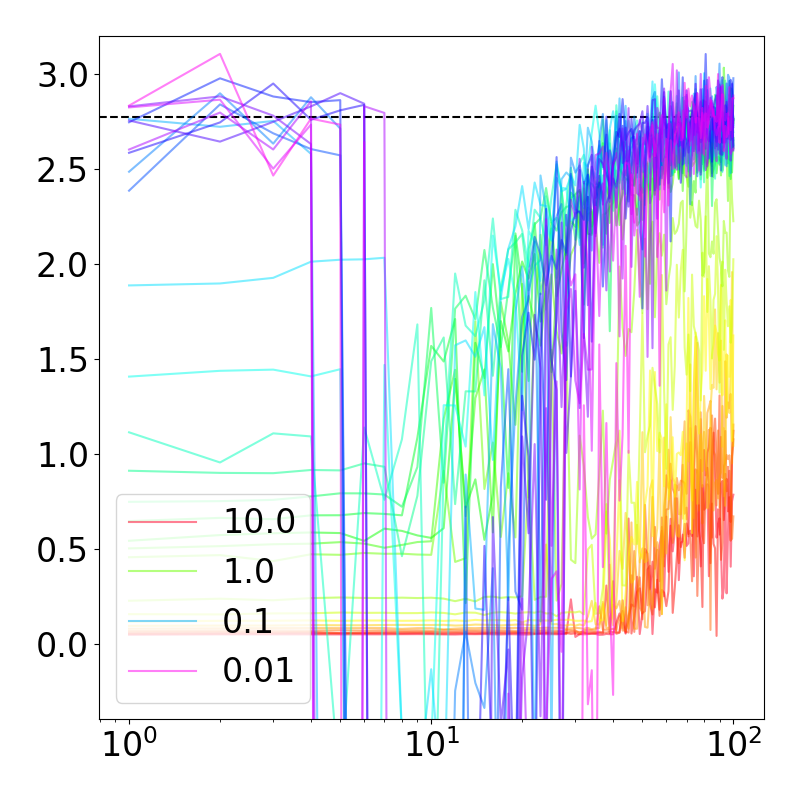

In [27]:
%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rc('font', size=24)

title = 'mi'

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_rainbow(np.linspace(0, 1, 29))))

plt.rcParams["figure.figsize"] = (8, 8)

for rw in rws[::-1]:
    x = []
    y = []
    for bs in bss:
        x.append(bs)
        y.append(imine_experiment_results[(bs, rw)][title])
    plt.plot(x, y, label=rw if rw in ('0.01', '0.1', '1.0', '10.0') else '_nolegend_', alpha=0.5)

plt.hlines((math.log(16), -math.log(16)), xmin=0, xmax=max(bss), linestyles='--')
plt.xscale('log')
plt.legend(loc='lower left')
plt.xticks([1, 10, 100])
if title == 'mi':
    plt.ylim(-0.4, 3.2)
elif title == 't':
    plt.ylim(-1, 60)
elif title == 'et':
    plt.ylim(-4, 100)
plt.tight_layout()
#plt.subplots_adjust(left=0.05, right=0.9, bottom=0.1, top=0.95)
plt.show()


<IPython.core.display.Javascript object>


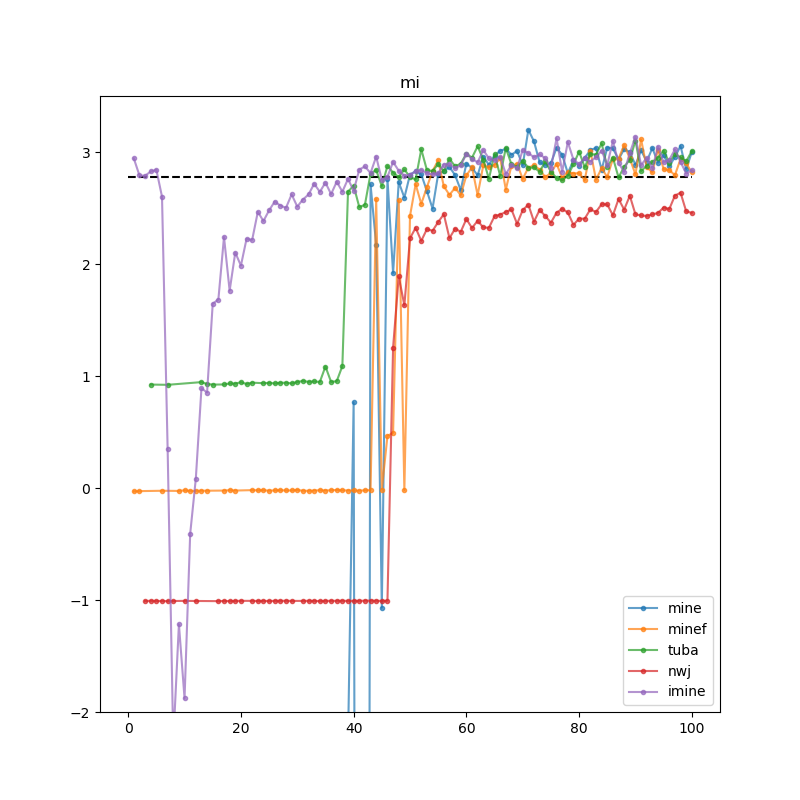

In [77]:
%matplotlib notebook
from matplotlib import pyplot as plt

title = 'mi'

mi = mi_factory('imine')

plt.rcParams["figure.figsize"] = (8, 8)

plt.hlines((math.log(16), -math.log(16)), xmin=0, xmax=max(bss), linestyles='--')
for l in target_loss + ['imine']:
    x = []
    y = []
    for bs in bss:
        value = others_experiment_results[(bs, l)][title]
        if not np.isnan(value):
            x.append(bs)
            y.append(others_experiment_results[(bs, l)][title])
    plt.plot(x, y, linestyle='-', marker='.', label=l, alpha=0.7)

#plt.xscale('log')
plt.legend()
plt.ylim(-2, 3.5)
# plt.yscale('symlog')
plt.title(title)
plt.show()


<IPython.core.display.Javascript object>


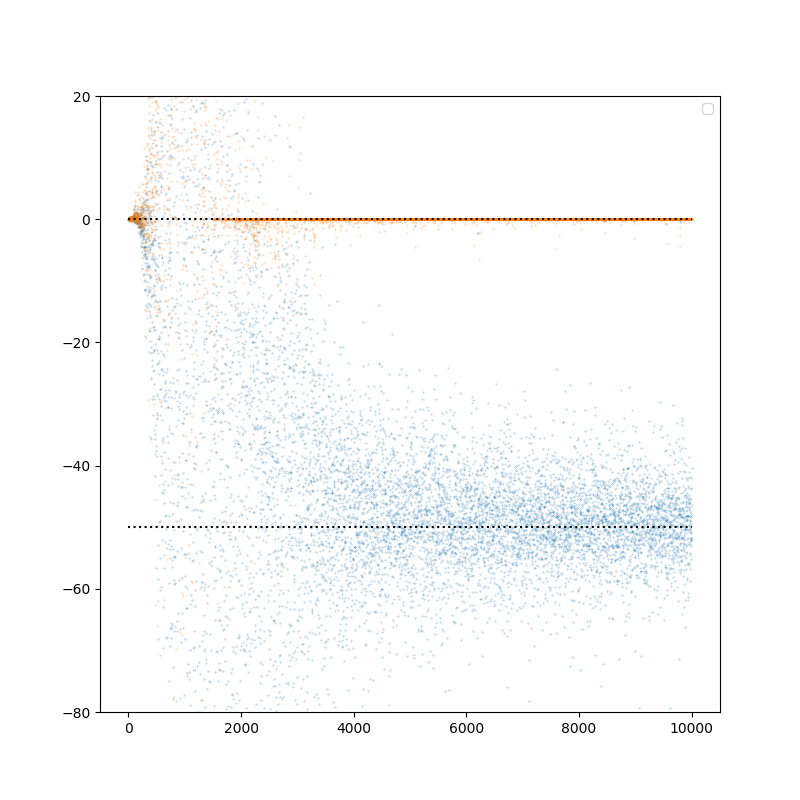

No handles with labels found to put in legend.


In [112]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np

plt.hlines((0, -50), xmin=0, xmax=len(df), linestyles='dotted')

df = pickle.load(open(f'single_history/0.01/1/0.pkl', 'rb'))[0]
plt.scatter(list(range(len(df))), df.marginal_value, s=0.1, alpha=0.5)
plt.scatter(list(range(len(df))), df.joint_value, s=0.1, alpha=0.5)

plt.ylim(-80, 20)
plt.legend()
plt.show()


%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
for i, start_iter in enumerate(['0.01', '0.02', '0.04', '0.08', '0.16']):
    plt.subplot(1, 6, i+1)
    
    mid = (max(agent.history.marginal_value[start_iter*100:start_iter*100+1000]) + min(agent.history.marginal_value[start_iter*100:start_iter*100+1000]))/2
    plt.hist(
        agent.history[(agent.history.is_joint_case == 0) & (agent.history.index >= start_iter * 100) & (agent.history.index <  start_iter * 100 + 1000)].marginal_value,
        bins=np.arange(mid-10, mid+10, 0.4),
        alpha=0.5
    )
    plt.hist(
        agent.history[(agent.history.is_joint_case == 1) & (agent.history.index >= start_iter * 100) & (agent.history.index <  start_iter * 100 + 1000)].marginal_value,
        bins=np.arange(mid-10, mid+10, 0.4),
        alpha=0.5
    )
    if i == 0:
        plt.title(f'Iteration {start_iter+1}~{start_iter+10}')
    else:
        plt.title(f'{start_iter+1}~{start_iter+10}')

plt.show()

In [96]:
df[0]

,is_joint_case,joint_value,marginal_value
0,1.0,0.032858,-0.000882
1,0.0,-0.012468,-0.009256
2,0.0,0.022524,0.037167
3,0.0,-0.089607,0.017499
4,0.0,-0.064401,-0.126707
...,...,...,...
9995,0.0,0.000000,-3.933520
9996,0.0,0.000000,-5.493351
9997,0.0,0.000000,-4.317523
9998,0.0,0.000000,-4.769839


<IPython.core.display.Javascript object>


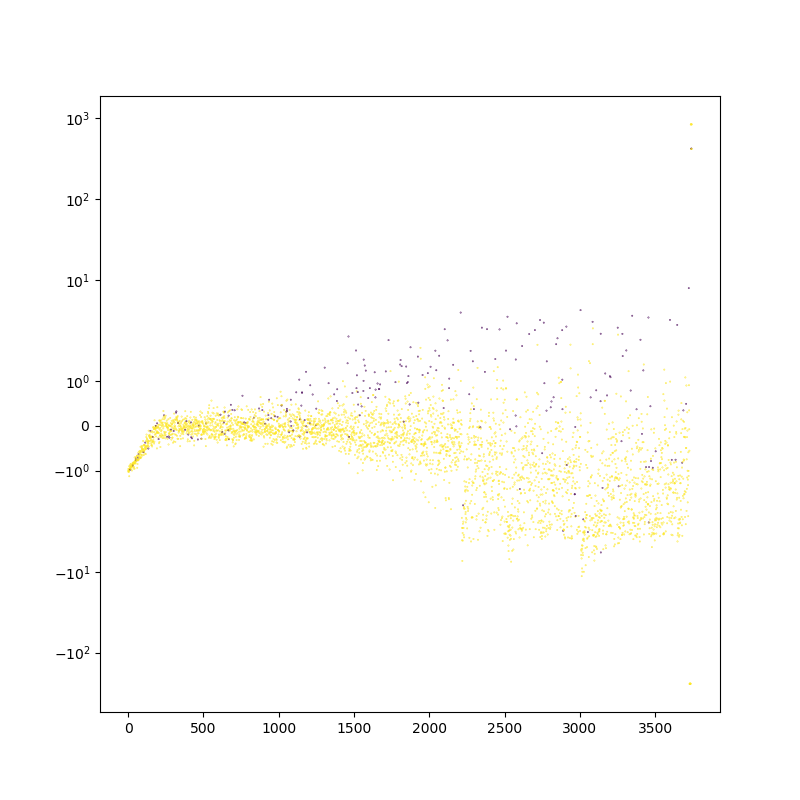

In [67]:
%matplotlib notebook
from matplotlib import pyplot as plt

df = pickle.load(open('single_history/nwj/8/0.pkl', 'rb'))

plt.scatter(list(range(len(df[0]))), df[0].marginal_value, s=0.1, alpha=1, c=1-df[0].is_joint_case)
# plt.scatter(list(range(len(df[0]))), df[0].joint_value, s=0.1, alpha=0.3)
plt.yscale('symlog')
# plt.ylim(-100, 100)